In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import numpy as np


## Preprocessing

In [3]:
folder_path = '../data/RLWM_examples'
# Get a list of all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
new_df_combined = pd.DataFrame()

for i, csv_file in enumerate(csv_files):
    df = pd.read_csv(csv_file)

    # Filter rows where 'trial_mode' is 'learning'
    df = df.loc[df['trial_mode'] == 'learning']
    # Remove "blockId" column
    df = df.drop(columns=['blockId'])
    # Create block number - block incremented by 1 for each new setId / setSize
    df['block'] = ((df['setId'] != df['setId'].shift()) | (df['setSize'] != df['setSize'].shift())).cumsum() - 1
    # Rename stimId based on block and setsize
    df['stimseq'] = df.groupby('block')['stimId'].transform(lambda x: pd.factorize(x)[0])
    # Calculate iteration numbers
    df['iterseq'] = df.groupby(['block', 'stimId']).cumcount() + 1

    # Calculate delays for previous correct trials
    # Get the previous "correct" = 1 index (excluding current row)
    df['prev_correct_index'] = (
        df.groupby(['block', 'stimId'])['correct']
        .transform(lambda x: x.index.to_series().where(x == 1).shift(1).ffill())
    )
    # Calculate delay and replace NaNs with -1
    df['delay_corr'] = (df.index - df['prev_correct_index']).fillna(-1)

    # Calculate leanring stages based on numbers of previous correct trials
    df['corr_count'] = (df['correct'] == 1).groupby([df['block'], df['stimId']]).cumsum()
    # First 1-3 correct trials are assigned 1 (early learning)
    # First 7 and after correct trials are assigned 2 (late learning)
    conditions = [
        (df['corr_count'] >= 1) & (df['corr_count'] <= 3),  # Assign 1
        (df['corr_count'] >= 4) & (df['corr_count'] <= 6),  # Assign 2
        (df['corr_count'] >= 7)                             # Assign 3
    ]
    choices = [1, 2, 3]
    df['learning'] = np.select(conditions, choices, default=-1)

    # Select specific columns from df
    selected_columns = df[['block', 'setSize', 'stimseq', 'stimId', 'setId', 'iterseq', 'correct', 
                           'delay_corr', 'corr_count', 'learning', 'rt']]
    # Rename the columns
    new_df = selected_columns.rename(columns={
        'setSize': 'ns',
        'stimId': 'imageseq',
        'setId': 'folderseq'
    }).astype(int)
    # Insert subjectID at the first position
    new_df.insert(0, 'subno', i)

    # Print some info
    # Calculate the proportion of each unique value in the 'correct' column
    proportions = new_df['correct'].value_counts(normalize=True)
    print(f"Participant {i}: Correct {proportions[1]*100:.2f}%; Incorrect {proportions[0]*100:.2f}%; No response {proportions[-1]*100:.2f}%")

    # Concatenate data for each participant into one df
    new_df_combined = pd.concat([new_df_combined, new_df], ignore_index=True)
    # Save preprocessed data
    new_df.to_csv(f'../data/preprocessed/prep_p{i}.csv', index=False)

new_df_combined.to_csv(f'../data/prep_all.csv', index=False)

# Descriptions about new_df structure
# 1. subno - subject ID
# 2. block - block number
# 3. ns - set size, the number of stimuli in each block
# 4. stimseq - stimulus id (transform real stimID to match setsize limit)
# 5. imageseq - actual image number
# 6. folderseq - image category number
# 7. iterseq - iteration number per stimulus, ranging from 1 to 10 for each stimulus
# 8. delay_corr - the trial interval since the current stimulus was last reinforced (delay) - is -1 when no correct previous response
# 9. corr_count - the number of previous correct responses for each stimulus
# 10. learning - learning stage (1: early [1-3 correct trials], 2: middle [4-6], 3: late [7-10], -1: the first counter of each stimulus)
# 11. rt - reaction time

Participant 0: Correct 65.45%; Incorrect 28.83%; No response 5.71%
Participant 1: Correct 74.81%; Incorrect 18.96%; No response 6.23%
Participant 2: Correct 81.56%; Incorrect 17.66%; No response 0.78%
Participant 3: Correct 76.10%; Incorrect 18.96%; No response 4.94%
Participant 4: Correct 61.04%; Incorrect 31.43%; No response 7.53%
Participant 5: Correct 63.64%; Incorrect 29.87%; No response 6.49%
Participant 6: Correct 60.00%; Incorrect 34.55%; No response 5.45%
Participant 7: Correct 74.55%; Incorrect 16.88%; No response 8.57%
Participant 8: Correct 51.43%; Incorrect 36.62%; No response 11.95%
Participant 9: Correct 52.99%; Incorrect 41.82%; No response 5.19%


## Plots

### Each participant

In [ ]:
folder_path = '../data/preprocessed'
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

for i, csv_file in enumerate(csv_files):
    df = pd.read_csv(csv_file)
    # Drop blocks where proportions of no responses exceed 30%
    proportion_filter = df.groupby(['subno', 'block'])['correct'].transform(lambda x: (x == -1).mean() <= 0.33)
    df = df[proportion_filter]
    # Remove trials with no response
    df = df[df['correct'] != -1]
    # Calculate the average accuracy
    grouped = df.groupby(['ns', 'iterseq'])['correct'].mean().reset_index()

    # Plot
    plt.figure(figsize=(10, 6))
    for ns_value in grouped['ns'].unique():
        subset = grouped[grouped['ns'] == ns_value]
        plt.plot(subset['iterseq'], subset['correct'], marker='o', linestyle='-', label=f'set size = {ns_value}')

    plt.title(f'Accuracy under different numbers of iterations (participant {i})')
    plt.xlabel('Previous Iterations')
    plt.ylabel('Accuracy')
    plt.legend(title='Set Size')
    plt.show()

### All participants

In [4]:
df = pd.read_csv('../data/prep_all.csv')
# Count sample size
n_subj = df['subno'].nunique()

# Remove the first block for every participant (training block)
df = df[df['block'] != 0]
# Drop blocks where proportions of no responses exceed 33%
proportion_filter = df.groupby(['subno', 'block'])['correct'].transform(lambda x: (x == -1).mean() <= 0.33)
df = df[proportion_filter]
# Remove trials with no response
df = df[df['correct'] != -1]

In [5]:
df.head()

,subno,block,ns,stimseq,imageseq,folderseq,iterseq,correct,delay_corr,corr_count,learning,rt
25,0,1,2,0,3,5,1,0,-1,0,-1,1105
26,0,1,2,0,3,5,2,0,-1,0,-1,822
28,0,1,2,0,3,5,3,0,-1,0,-1,472
29,0,1,2,1,5,5,2,0,-1,0,-1,663
30,0,1,2,1,5,5,3,0,-1,0,-1,837


#### Speed-accuracy trade-off

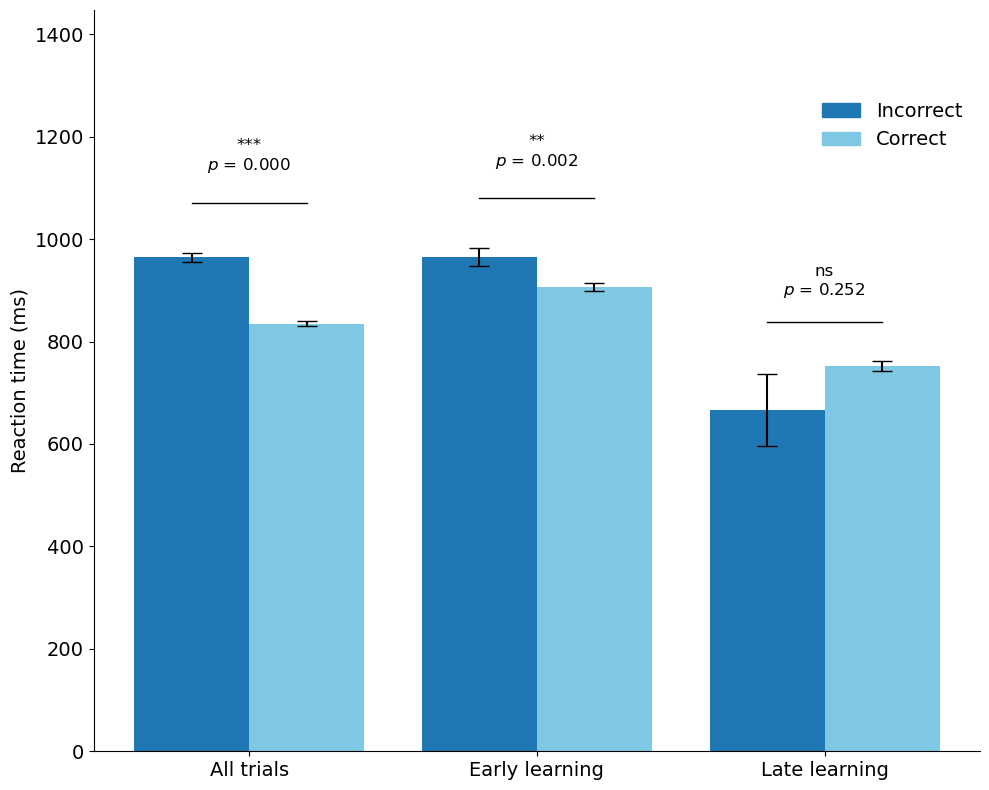

In [17]:
conditions = [
    (0, None), (1, None),  # Overall
    (0, 1), (1, 1),        # Learning 1
    (0, 3), (1, 3)         # Learning 3
]

# Generate data series
rts = [
    df[(df['correct'] == c) & (df['learning'] == l if l else df['correct'] == c)]['rt']
    for c, l in conditions
]

# Calculate means and SEMs
means = [rt.mean() for rt in rts]
ses = [rt.sem() for rt in rts]

# Visualization parameters
bar_width = 0.2
x_pos = [0.4, 0.6, 0.9, 1.1, 1.4, 1.6]  # Three groups
colors = ['#1f77b4', '#7ec8e3'] * 3     # Alternate colors for incorrect/correct
group_labels = ['All trials', 'Early learning', 'Late learning']
xticks_pos = [0.5, 1.0, 1.5]            # Group label centers

plt.figure(figsize=(10, 8))

# Create bars with error caps
bars = plt.bar(x_pos, means, width=bar_width,
               yerr=ses, capsize=7, color=colors, 
               edgecolor='none')

# Set up axes
plt.xticks(xticks_pos, group_labels, fontsize=14)
plt.ylabel('Reaction time (ms)', fontsize=14)
plt.ylim(0, max(means) * 1.5)
plt.yticks(fontsize=14)
plt.gca().spines[['top', 'right']].set_visible(False)

# Statistical annotations
groups = [(0,1), (2,3), (4,5)]  # Bar indices for each group
for idx, (i,j) in enumerate(groups):
    t_stat, p = stats.ttest_ind(rts[i], rts[j], equal_var=False)
    
    # Determine significance stars
    if p < 0.001:
        stars = '***'
    elif p < 0.01:
        stars = '**'
    elif p < 0.05:
        stars = '*'
    else:
        stars = 'ns'
    
    # Calculate annotation position
    y_base = max(means[i] + ses[i], means[j] + ses[j])
    line_y = y_base * 1.1
    text_y = line_y * 1.05
    
    # Draw significance markers
    plt.plot([x_pos[i], x_pos[j]], [line_y]*2, '-', color='k', lw=1)
    plt.text(np.mean([x_pos[i], x_pos[j]]), text_y, 
             f'{stars}\n$p$ = {p:.3f}', 
             ha='center', va='bottom', fontsize=12)

# Create simplified legend
legend_elements = [
    plt.Rectangle((0,0),1,1, color='#1f77b4', label='Incorrect'),
    plt.Rectangle((0,0),1,1, color='#7ec8e3', label='Correct')
]
plt.legend(handles=legend_elements,
           frameon=False,
           bbox_to_anchor=(1, 0.9),
           fontsize=14)

plt.tight_layout()
plt.show()

#### Set size * Iterations

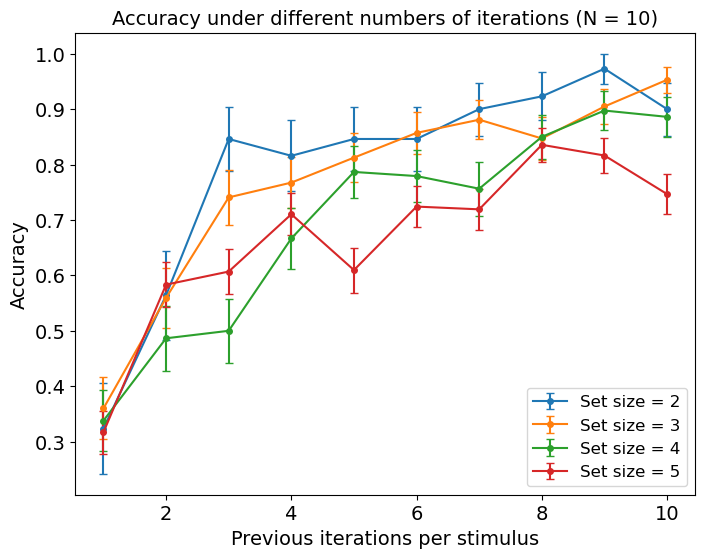

In [8]:
# Calculate the average accuracy
grouped = df.groupby(['ns', 'iterseq'])['correct'].agg(['mean', 'sem']).reset_index()

# Plot
plt.figure(figsize=(8, 6))
for i, ns_value in enumerate(grouped['ns'].unique()):
    subset = grouped[grouped['ns'] == ns_value]
    
    errorbar_plot = plt.errorbar(
        x=subset['iterseq'],
        y=subset['mean'],
        yerr=subset['sem'],
        marker='o',
        linestyle='-',
        markersize=4,
        label=f'Set size = {ns_value}',
        capsize=3
    )

plt.title(f'Accuracy under different numbers of iterations (N = {n_subj})', fontsize=14)
plt.xlabel('Previous iterations per stimulus', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

(array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05]),
 [Text(0, 0.6000000000000001, '0.60'),
  Text(0, 0.6500000000000001, '0.65'),
  Text(0, 0.7000000000000001, '0.70'),
  Text(0, 0.7500000000000001, '0.75'),
  Text(0, 0.8, '0.80'),
  Text(0, 0.8500000000000001, '0.85'),
  Text(0, 0.9000000000000001, '0.90'),
  Text(0, 0.9500000000000002, '0.95'),
  Text(0, 1.0, '1.00'),
  Text(0, 1.05, '1.05')])

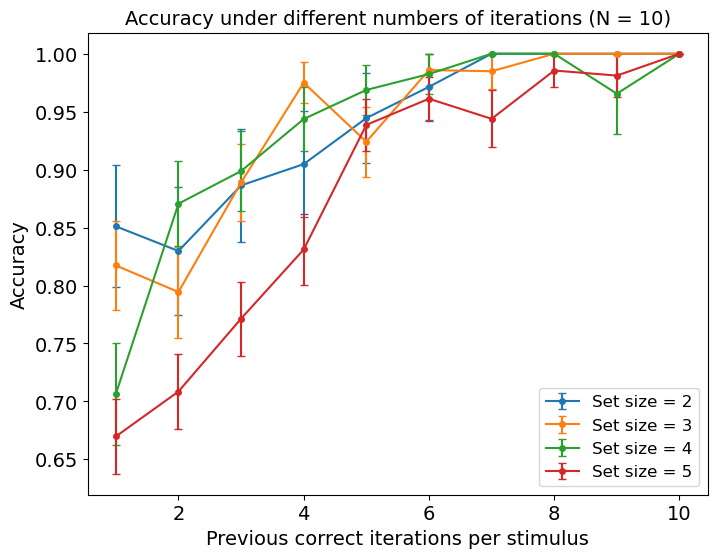

In [ ]:
df_1 = df[df['corr_count'] != 0]
# Calculate the average accuracy
grouped = df_1.groupby(['ns', 'corr_count'])['correct'].agg(['mean', 'sem']).reset_index()

# Plot
plt.figure(figsize=(8, 6))
for i, ns_value in enumerate(grouped['ns'].unique()):
    subset = grouped[grouped['ns'] == ns_value]
    errorbar_plot = plt.errorbar(
        x=subset['corr_count'],
        y=subset['mean'],
        yerr=subset['sem'],
        marker='o',
        linestyle='-',
        markersize=4,
        label=f'Set size = {ns_value}',
        capsize=3
    )

plt.title(f'Accuracy under different numbers of iterations (N = {n_subj})', fontsize=14)
plt.xlabel('Previous correct iterations per stimulus', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#### Set size * Delay

C:\Users\ausra\AppData\Local\Temp\ipykernel_29748\1706823432.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['delay_grp'] = np.where(df_2['delay_corr'] >= 5, '5+', df_2['delay_corr'])


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

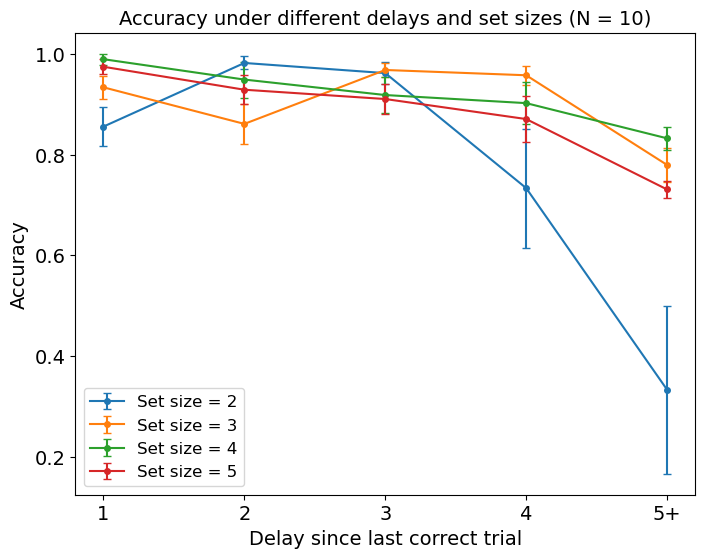

In [10]:
# Remove trials where delays are -1
df_2 = df[df['delay_corr'] != -1]
# All values higher than n in "delay_corr" are integrated into the same group
df_2['delay_grp'] = np.where(df_2['delay_corr'] >= 5, '5+', df_2['delay_corr'])
# Calculate the average accuracy
grouped = df_2.groupby(['ns', 'delay_grp'])['correct'].agg(['mean', 'sem']).reset_index()

# Plot
plt.figure(figsize=(8, 6))
for i, ns_value in enumerate(grouped['ns'].unique()):
    subset = grouped[grouped['ns'] == ns_value]
    errorbar_plot = plt.errorbar(
        x=subset['delay_grp'],
        y=subset['mean'],
        yerr=subset['sem'],
        marker='o',
        linestyle='-',
        markersize=4,
        label=f'Set size = {ns_value}',
        capsize=3
    )

plt.title(f'Accuracy under different delays and set sizes (N = {n_subj})', fontsize=14)
plt.xlabel('Delay since last correct trial', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#### Learning stage * Delay

(array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
 [Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.7000000000000001, '0.7'),
  Text(0, 0.8, '0.8'),
  Text(0, 0.9, '0.9'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.1, '1.1')])

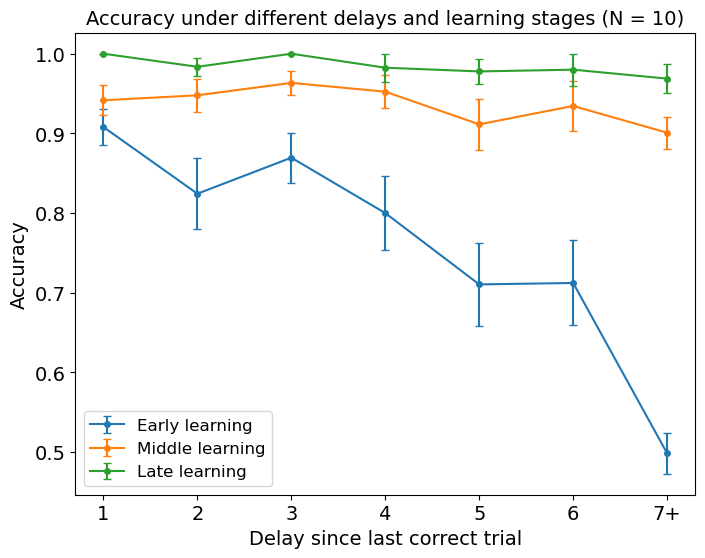

In [12]:
# Remove trials where learning and delay are -1
df_3 = df[df['delay_corr'] != -1]
df_3 = df_3[df_3['learning'] != -1]
# All values higher than n in "delay_corr" are integrated into the same group
df_3['delay_grp'] = np.where(df_3['delay_corr'] >= 7, '7+', df_3['delay_corr'])
# Calculate the average accuracy
grouped = df_3.groupby(['learning', 'delay_grp'])['correct'].agg(['mean', 'sem']).reset_index()

# Plot
labels = ['Early learning', 'Middle learning', 'Late learning']
plt.figure(figsize=(8, 6))
for i, ns_value in enumerate(grouped['learning'].unique()):
    subset = grouped[grouped['learning'] == ns_value]
    errorbar_plot = plt.errorbar(
        x=subset['delay_grp'],
        y=subset['mean'],
        yerr=subset['sem'],
        marker='o',
        linestyle='-',
        markersize=4,
        label=f'{labels[i]}',
        capsize=3
    )

plt.title(f'Accuracy under different delays and learning stages (N = {n_subj})', fontsize=14)
plt.xlabel('Delay since last correct trial', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#### Learning stage * Set size

(array([0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05]),
 [Text(0, 0.55, '0.55'),
  Text(0, 0.6000000000000001, '0.60'),
  Text(0, 0.65, '0.65'),
  Text(0, 0.7000000000000001, '0.70'),
  Text(0, 0.75, '0.75'),
  Text(0, 0.8, '0.80'),
  Text(0, 0.8500000000000001, '0.85'),
  Text(0, 0.9000000000000001, '0.90'),
  Text(0, 0.9500000000000001, '0.95'),
  Text(0, 1.0, '1.00'),
  Text(0, 1.05, '1.05')])

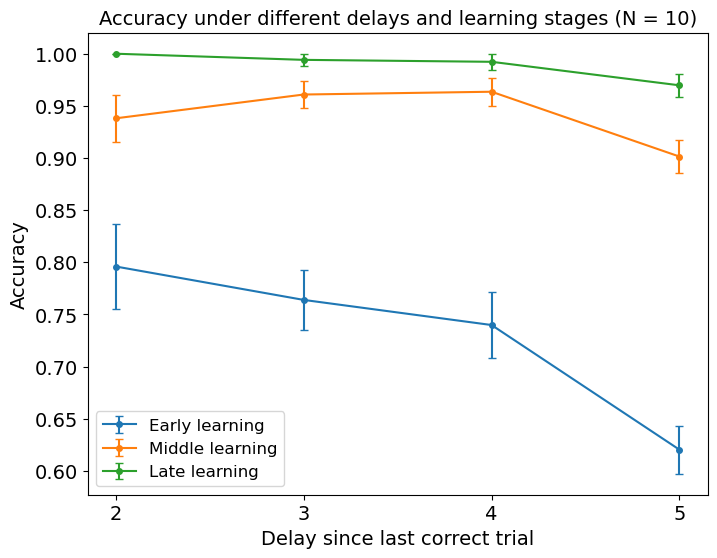

In [14]:
# Remove trials where learning and delay are -1
df_3 = df[df['delay_corr'] != -1]
df_3 = df_3[df_3['learning'] != -1]
# Calculate the average accuracy
grouped = df_3.groupby(['learning', 'ns'])['correct'].agg(['mean', 'sem']).reset_index()

# Plot
labels = ['Early learning', 'Middle learning', 'Late learning']
plt.figure(figsize=(8, 6))
for i, ns_value in enumerate(grouped['learning'].unique()):
    subset = grouped[grouped['learning'] == ns_value]
    errorbar_plot = plt.errorbar(
        x=subset['ns'],
        y=subset['mean'],
        yerr=subset['sem'],
        marker='o',
        linestyle='-',
        markersize=4,
        label=f'{labels[i]}',
        capsize=3
    )

plt.xticks(
    ticks=[2, 3, 4, 5],
    labels=['2', '3', '4', '5'],
    fontsize=14
)

plt.title(f'Accuracy under different delays and learning stages (N = {n_subj})', fontsize=14)
plt.xlabel('Delay since last correct trial', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.yticks(fontsize=14)

### Predicted accuracy
Not a good practice but you need to fit regression models in R before runnign following codes

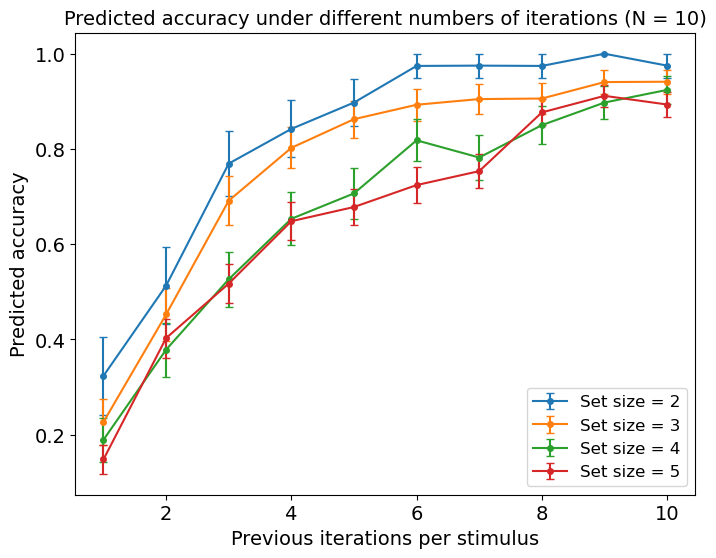

In [20]:
df = pd.read_csv('../data/predicted_all.csv') # no need to preprocess again; already clean

# Calculate the average accuracy
grouped = df.groupby(['ns', 'iterseq'])['predicted_correct'].agg(['mean', 'sem']).reset_index()

# Plot
plt.figure(figsize=(8, 6))
for i, ns_value in enumerate(grouped['ns'].unique()):
    subset = grouped[grouped['ns'] == ns_value]
    
    errorbar_plot = plt.errorbar(
        x=subset['iterseq'],
        y=subset['mean'],
        yerr=subset['sem'],
        marker='o',
        linestyle='-',
        markersize=4,
        label=f'Set size = {ns_value}',
        capsize=3
    )

plt.title(f'Predicted accuracy under different numbers of iterations (N = {n_subj})', fontsize=14)
plt.xlabel('Previous iterations per stimulus', fontsize=14)
plt.ylabel('Predicted accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()